[The Augmented Lagrange Multiplier Method for Exact Recovery of Corrupted Low-Rank Matrices][LIN2009] (Zhouchen Lin, Minming Chen, Yi Ma)

[LIN2009]: https://arxiv.org/abs/1009.5055

## Synthetic Data

In [1]:
%matplotlib inline

In [2]:
import sys

sys.path.append('./rpca')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rpca.transformer import RobustPCA

In [4]:
plt.style.use('ggplot')

In [5]:
np.random.seed(seed=1525277520)

In [6]:
N_SAMPLES = 100
FREQUENCY = 3
AMPLITUDE = 30

In [7]:
signal_pattern = np.array([AMPLITUDE * np.sin(2 * np.pi * FREQUENCY * n * N_SAMPLES**-1) for n in range(N_SAMPLES)])

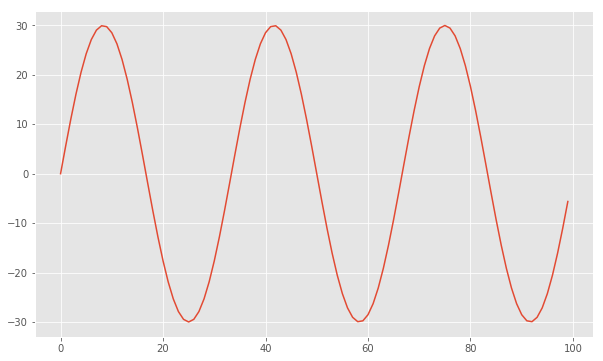

In [8]:
pd.DataFrame(signal_pattern).plot(figsize=(10, 6), legend=False);

In [9]:
N_SENSORS = 100
MU = 0
SIGMA = 6

sensors = []
signals_mean = []

for _ in range(N_SENSORS):
    noise = np.random.randn(N_SAMPLES) * SIGMA  + MU
    mean = ((np.random.randn() + 1) * .5) * 100 + 50
    
    signals_mean.append(mean)
    sensors.append(np.add(signal_pattern + mean, noise))
    
timeseries = np.vstack(sensors)

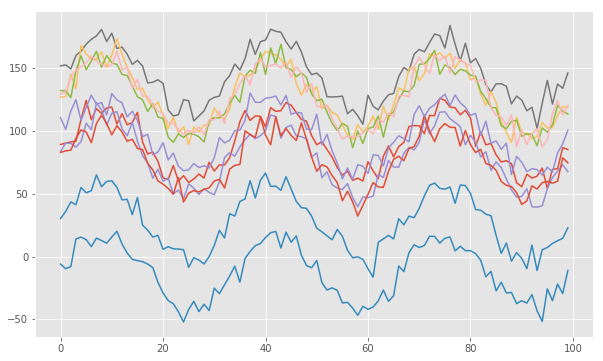

In [10]:
pd.DataFrame(timeseries[:10].T).plot(figsize=(10, 6), legend=False);

In [11]:
with_anomaly = np.random.rand(N_SENSORS) < 0.1

In [12]:
ANOMALY_DURATION = 10

for i, v in enumerate(with_anomaly):
    if v:
        r = np.random.randint(60)
        anomaly = np.random.normal(0, 10, ANOMALY_DURATION) + signals_mean[i] 
        timeseries[i, r:r+ANOMALY_DURATION] = anomaly

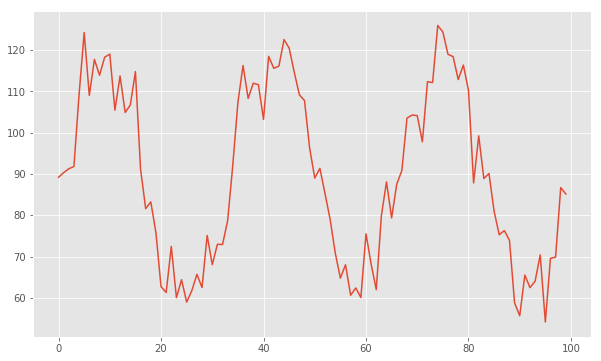

In [13]:
pd.DataFrame(timeseries[with_anomaly == False].T)[0].plot(figsize=(10, 6), legend=False);

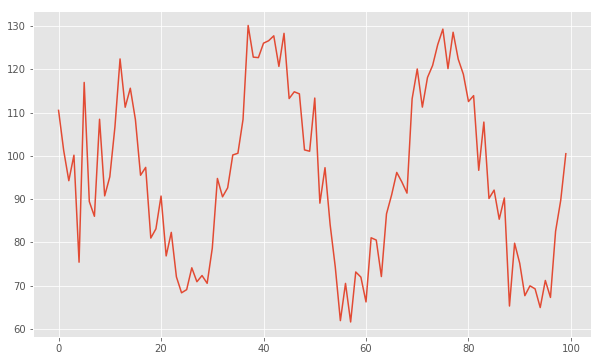

In [14]:
pd.DataFrame(timeseries[with_anomaly].T)[0].plot(figsize=(10, 6), legend=False);

In [15]:
model = RobustPCA(method='lowrank')

In [16]:
lowrank_signals = model.transform(timeseries)

In [17]:
estimated_anomalies = model.S_

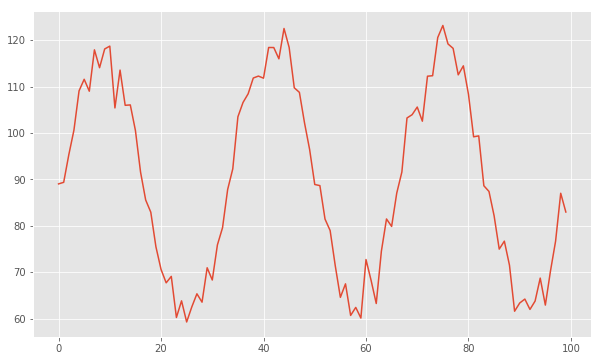

In [18]:
pd.DataFrame(lowrank_signals[with_anomaly == False][0].T).plot(figsize=(10, 6), legend=False);

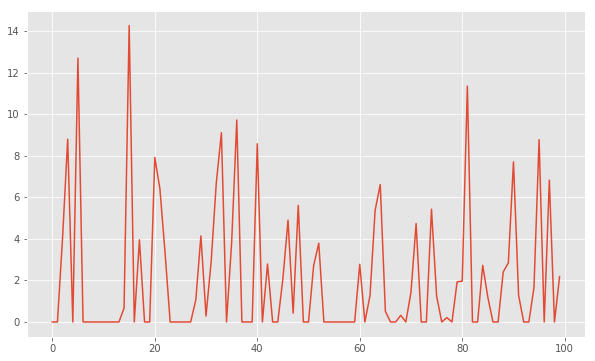

In [19]:
pd.DataFrame(np.abs(estimated_anomalies[with_anomaly == False][0].T)).plot(figsize=(10, 6), legend=False);

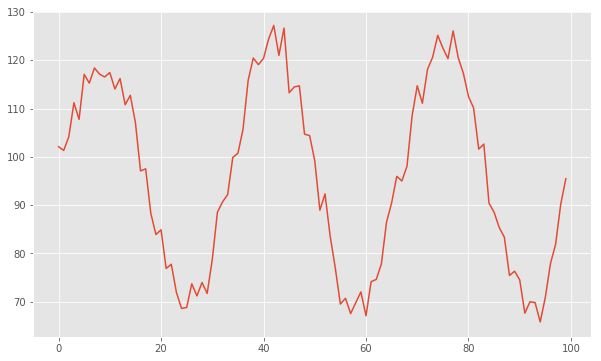

In [20]:
pd.DataFrame(lowrank_signals[with_anomaly][0].T).plot(figsize=(10, 6), legend=False);

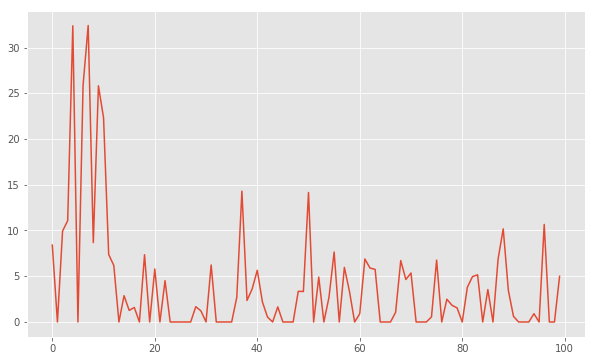

In [21]:
pd.DataFrame(np.abs(estimated_anomalies[with_anomaly][0]).T).plot(figsize=(10, 6), legend=False);

In [22]:
np.mean(estimated_anomalies), np.std(estimated_anomalies)

(0.3170303094279608, 4.347469038725611)

In [23]:
estimated_norm = (estimated_anomalies - np.mean(estimated_anomalies)) / np.std(estimated_anomalies)

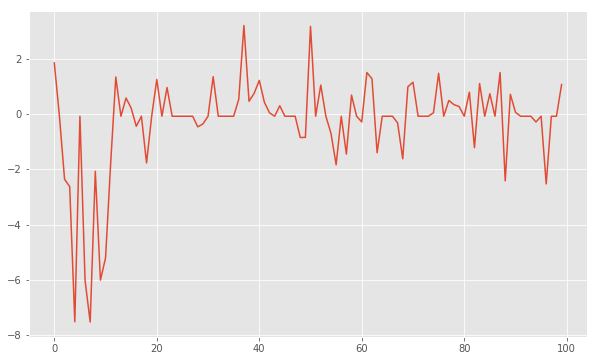

In [24]:
pd.DataFrame(estimated_norm[with_anomaly][0].T).plot(figsize=(10, 6), legend=False);

## Real World Data

In [25]:
elb_df = pd.read_csv("data/ec2_cpu_utilization_5f5533.csv", index_col='timestamp', sep=',', parse_dates=True)

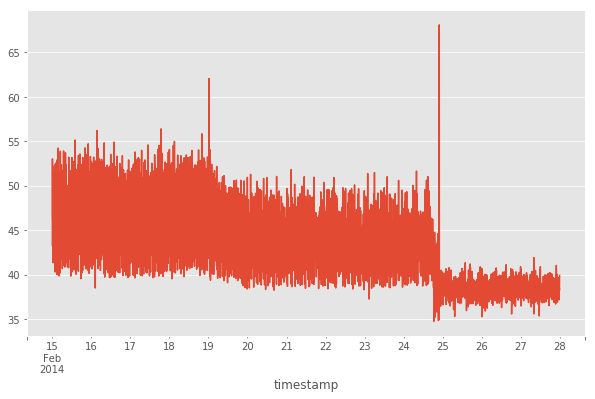

In [26]:
elb_df.resample('5min').mean().plot(figsize=(10, 6), legend=False);

In [27]:
elb_df['day'] = elb_df.index.day
elb_df['hour'] = elb_df.index.hour
elb_df['minute'] = elb_df.index.minute

elb_by_day = elb_df.set_index(['day', 'hour', 'minute']).unstack(['day'])

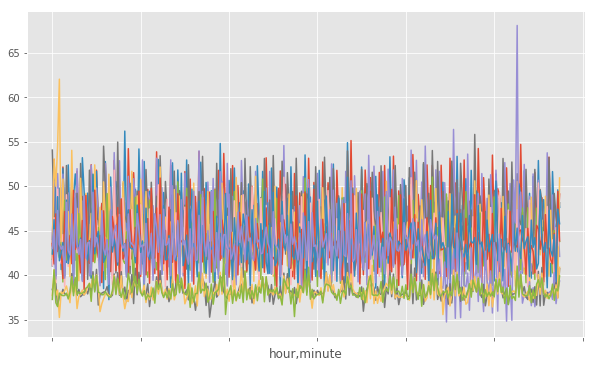

In [28]:
elb_by_day.plot(figsize=(10, 6), legend=False);

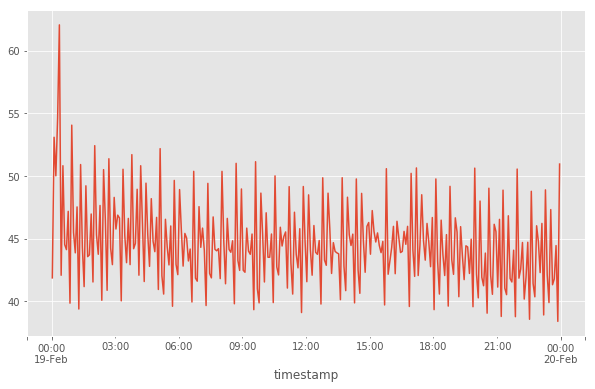

In [29]:
elb_df[elb_df['day'] == 19]['value'].plot(figsize=(10, 6), legend=False);

In [30]:
elb_by_day.shape

(288, 13)

In [31]:
elb_model = RobustPCA()

In [32]:
elb_by_day = elb_by_day.fillna(elb_by_day.mean())

In [33]:
elb_by_day.head()

value                                                           \
day              15      16      17      18       19      20      21      22   
hour minute                                                                    
0    2       43.310  41.064  44.062  54.084  41.8780  41.822  41.080  43.582   
     7       53.028  52.730  50.540  46.596  53.0920  41.680  46.486  41.276   
     12      46.644  46.996  41.310  43.226  50.0150  46.198  39.108  46.916   
     17      46.124  42.998  51.448  48.798  54.6033  42.916  49.694  42.696   
     22      47.802  49.798  46.066  46.588  62.0560  41.976  42.370  43.522   

                                                     
day              23      24      25      26      27  
hour minute                                          
0    2       42.408  43.024  38.404  37.746  37.300  
     7       46.268  45.128  39.272  40.618  40.634  
     12      39.948  39.578  39.062  37.750  36.924  
     17      48.850  47.302  36.616  38.356  36.496  
     22      41.644  43.474  37.658  35.278  38.014

In [34]:
elb_sparse = elb_model.transform(elb_by_day.values.T)
elb_lowrank = elb_model.L_

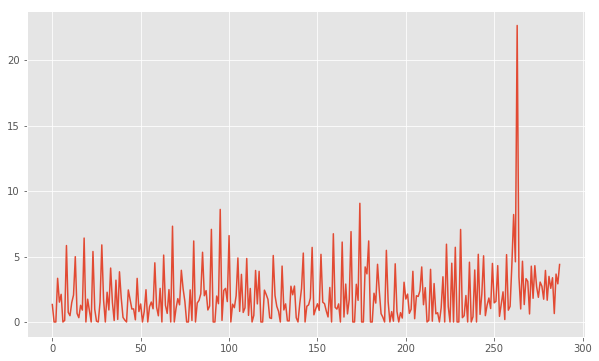

In [35]:
pd.DataFrame(np.abs(elb_sparse.T))[9].plot(figsize=(10, 6), legend=False);

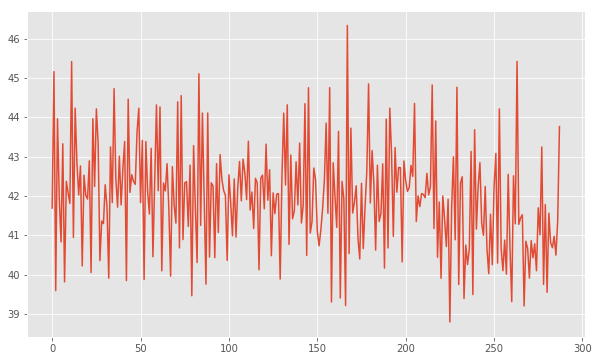

In [36]:
pd.DataFrame(elb_lowrank.T)[9].plot(figsize=(10, 6), legend=False);